# Taller 1: Regresión lineal, Ridge y Lasso
**Nombres:** 
- Juan Manuel Ramirez
- Dayana Gonzalez vargas

En este taller analizaremos métodos de regresión lineal para el conjunto de datos [Hitters](https://www.kaggle.com/datasets/floser/hitters). Cada registro corresponde a un jugador de baseball. Las variables son registros como cantidad de *home runs* o número de años en las ligas mayores. La variable objetivo es el salario de dicho jugador. 
Usaremos regresión de Ridge y Lasso y las compararemos. 

- El taller consiste en realizar todas las tareas señaladas con **TO_DO**. 

- Se puede realizar de forma individual o en parejas.

- Subir el cuaderno en dos formatos : 1. En formato .ipynb  2. En formato .html.
- Subirlo al aula a más tardar el miércoles 15 de ferbero.



In [1]:
#importar paquetes
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
import random

In [2]:
#Evitar la impresión de warnings
import warnings
warnings.filterwarnings("ignore")

En primer lugar, leemos el conjunto de datos e imprimimos la información sobre sus columnas.

In [14]:
df = pd.read_csv('Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

In [15]:
#TO_DO 1: Codificar las 3 variables categóricas como variables Dummy (usar por ejemplo el
#método get_dummies de Pandas). 
df = pd.get_dummies(df, ['League','Division','NewLeague'])
#volver las variables categoricas a numero

In [16]:
#Verificar la codificación anterior
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


In [18]:
# Definimos la columna y, correspondiente a la variable objetivo.
y = df.Salary

#TO_DO 2:
#Eliminar la columna con la variable dependiente (Salary) y de ser necesario, las columnas originales para las que se crearon
#variables dummy. Dar a la nueva tabla de atributos el nombre X (mayúscula).
X = df.drop(columns = ['Salary'])

#Verificar lo anterior
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AtBat        263 non-null    int64
 1   Hits         263 non-null    int64
 2   HmRun        263 non-null    int64
 3   Runs         263 non-null    int64
 4   RBI          263 non-null    int64
 5   Walks        263 non-null    int64
 6   Years        263 non-null    int64
 7   CAtBat       263 non-null    int64
 8   CHits        263 non-null    int64
 9   CHmRun       263 non-null    int64
 10  CRuns        263 non-null    int64
 11  CRBI         263 non-null    int64
 12  CWalks       263 non-null    int64
 13  PutOuts      263 non-null    int64
 14  Assists      263 non-null    int64
 15  Errors       263 non-null    int64
 16  League_A     263 non-null    uint8
 17  League_N     263 non-null    uint8
 18  Division_E   263 non-null    uint8
 19  Division_W   263 non-null    uint8
 20  NewLeague_

Vamos a generar valores de Lambda equidistantes para experimentar sobre un intervalo. Estos valores se encuentran entre 10^(-2) y 10^10. Experimentaremos con 100 valores distintos de lambda. Para esto usamos *linspace* de Numpy:

In [19]:
# Creamos una lista con posibles valores para el parámetro Lambda para los algoritmos Ridge y Lasso
lambdas = 10**np.linspace(10,-2,100)
lambdas

array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+07, 2.15443469e+07, 1.62975083e+07,
       1.23284674e+07, 9.32603347e+06, 7.05480231e+06, 5.33669923e+06,
       4.03701726e+06, 3.05385551e+06, 2.31012970e+06, 1.74752840e+06,
       1.32194115e+06, 1.00000000e+06, 7.56463328e+05, 5.72236766e+05,
       4.32876128e+05, 3.27454916e+05, 2.47707636e+05, 1.87381742e+05,
       1.41747416e+05, 1.07226722e+05, 8.11130831e+04, 6.13590727e+04,
       4.64158883e+04, 3.51119173e+04, 2.65608778e+04, 2.00923300e+04,
       1.51991108e+04, 1.14975700e+04, 8.69749003e+03, 6.57933225e+03,
       4.97702356e+03, 3.76493581e+03, 2.84803587e+03, 2.15443469e+03,
      

Vamos a usar el algoritmo de Ridge de SKlearn para hacer regresión con los diferentes valores del parámetro Lambda, de manera que podamos realizar algunas observaciones y comparaciones.

In [42]:
# Aplicamos el algoritmo Ridge de SKlearn para los diferentes valores de Lambda definidos
# en la celda anterior. Guardar los vectores obtenidos de parámetros en la lista coefs.
ridge = Ridge(normalize = True)
coefs = []

for a in lambdas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
#Imprimir las dimensiones de la matriz coef.   
np.shape(coefs)

(100, 22)

Usamos los arreglos *lambdas* y *coefs* para comparar los resultados de la regresión Ridge para diferentes valores del parámetro Lambda.

Text(0, 0.5, 'weights')

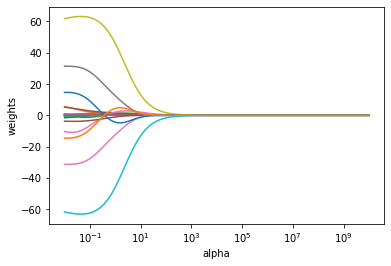

In [43]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

TO_DO 3: Hallar el coeficiente de las variables Hits Runs y Walks, arrojado por el algoritmo Ridge, para 3 lambdas distintos.
Ejemplo: "Para lambda=3.06795364e+00, el coeficiente de Hits es (valor), el coeficiente de Runs es (valor) y el coeficiente de Walks es (valor)."

**Respuesta:**

In [44]:
ridge.set_params(alpha = .5)
ridge.fit(X, y)
print("Para lambda =", 0.5, ", el coeficiente de Hits es", ridge.coef_[1], ", el coeficiente de Runs es ", ridge.coef_[3], "y el coeficiente de Walks es", ridge.coef_[5])

ridge.set_params(alpha = 3.06795364)
ridge.fit(X, y)
print("Para lambda =", 3.06795364, ", el coeficiente de Hits es", ridge.coef_[1],", el coeficiente de Runs es ", ridge.coef_[3], "y el coeficiente de Walks es", ridge.coef_[5])

ridge.set_params(alpha = 3.5)
ridge.fit(X, y)
print("Para lambda =", 3.5, ", el coeficiente de Hits es", ridge.coef_[1],", el coeficiente de Runs es ", ridge.coef_[3], "y el coeficiente de Walks es", ridge.coef_[5])


Para lambda = 0.5 , el coeficiente de Hits es 0.9834042713537325 , el coeficiente de Runs es  1.0946748134817357 y el coeficiente de Walks es 1.7693081978700638
Para lambda = 3.06795364 , el coeficiente de Hits es 0.50580499812353 , el coeficiente de Runs es  0.7770918104425876 y el coeficiente de Walks es 1.040984238441106
Para lambda = 3.5 , el coeficiente de Hits es 0.47807904310606386 , el coeficiente de Runs es  0.7423726967181855 y el coeficiente de Walks es 0.9867185830422165


A continuación separamos el conjunto de datos en conjunto de Entrenamiento y Testeo.

In [62]:
#TO_DO 4: 
#Escoger random_sate = 0. Y partir el conjunto de datos en Entrenamiento y Testeo, con porcentaje de Testeo de 20%

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.20, random_state=0)

Apliquemos el algoritmo de regresión lineal de SKLearn a éste conjunto de datos.

In [66]:
#TO_DO 5: Aplicar el algoritmo de regresión lineal de SKLearn a éste conjunto de datos e
# imprimir su coeficiente de determinación R^2 (score)
regr = LinearRegression().fit(X_train,Y_train)
regr.score(X,y)

0.5301735180942861

TO_DO 6: Cuáles son los valores de los parámetros en el modelo lineal obtenido? (Pista: En el taller anterior eran la pendiente y el punto de corte.) Cuál valor corresponde con cuál variable en el Dataset?

**Respuesta:**

In [67]:
X.columns
#regr.coef_
print(pd.Series(regr.coef_, index = X.columns))

AtBat          -1.834146
Hits            7.021244
HmRun          11.279774
Runs           -1.786829
RBI            -2.910850
Walks           7.360806
Years           5.858296
CAtBat         -0.149143
CHits           0.306629
CHmRun         -0.652869
CRuns           1.016259
CRBI            0.695087
CWalks         -0.863273
PutOuts         0.193153
Assists         0.459977
Errors         -5.810322
League_A      -16.099322
League_N       16.099322
Division_E     57.276941
Division_W    -57.276941
NewLeague_A    -2.118528
NewLeague_N     2.118528
dtype: float64


## Regresión Ridge
Ahora apliquemos Regresión de Ridge para algunos valores de lambda. En primer lugar usemos Lambda=4. 

In [69]:
#Modelo de regresión de Ridge para Lambda=4
# Note el uso del parámetro normalize=True
ridge = Ridge(alpha = 4, normalize = True)
ridge.fit(X_train, Y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("MSE:",mean_squared_error(Y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("R2",ridge.score(X_test, Y_test))         #Imprimir el coeficiente de determinación R^2

AtBat           0.111406
Hits            0.467295
HmRun           1.365857
Runs            0.778508
RBI             0.646139
Walks           0.966759
Years           2.796045
CAtBat          0.008318
CHits           0.032662
CHmRun          0.219125
CRuns           0.065070
CRBI            0.065515
CWalks          0.060097
PutOuts         0.048401
Assists         0.023814
Errors         -0.396742
League_A       -3.503111
League_N        3.503111
Division_E     20.698058
Division_W    -20.698058
NewLeague_A    -4.763146
NewLeague_N     4.763146
dtype: float64
MSE: 177295.1880623487
R2 0.39711269272001215


In [76]:
#TO_DO 7 Hacer regresión Ridge para lambda=10^10. Imprimir los coeficientes obtenidos y el error MSE
# Usar el parámetro normalize=True
ridge = Ridge(alpha = 10**10, normalize = True)
ridge.fit(X_train, Y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("MSE:",mean_squared_error(Y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("R2",ridge.score(X_test, Y_test))         #Imprimir el coeficiente de determinación R^2

AtBat          1.199328e-10
Hits           4.318179e-10
HmRun          1.650614e-09
Runs           7.511952e-10
RBI            7.227535e-10
Walks          8.969918e-10
Years          3.478858e-09
CAtBat         9.426433e-12
CHits          3.471758e-11
CHmRun         2.742106e-10
CRuns          6.998938e-11
CRBI           7.355186e-11
CWalks         7.564463e-11
PutOuts        3.687963e-11
Assists        2.030162e-11
Errors        -3.698884e-13
League_A      -8.582518e-10
League_N       8.582518e-10
Division_E     1.249941e-08
Division_W    -1.249941e-08
NewLeague_A   -2.321768e-09
NewLeague_N    2.321768e-09
dtype: float64
MSE: 297431.0635741096
R2 -0.011405977676945955


TO_DO 8: Cuál debería ser el coeficiente de determinación R^2 al asignar Lambda=0? Justifique y compruebe en la siguiente celda.

**Respuesta y justificación:**

El valor de R^2 debe ser el maximo debido a que no se imponen limitaciones adicionales a las variables permitiendo que expliquen mas de la varianza de los datos considerados

In [73]:
# TO_DO 9 Verifique su respuesta anterior.
# Usar el parámetro normalize=True
ridge = Ridge(alpha = 0, normalize = True)
ridge.fit(X_train, Y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("MSE:",mean_squared_error(Y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("R2",ridge.score(X_test, Y_test))  

AtBat          -1.834146
Hits            7.021244
HmRun          11.279774
Runs           -1.786829
RBI            -2.910850
Walks           7.360806
Years           5.858296
CAtBat         -0.149143
CHits           0.306629
CHmRun         -0.652869
CRuns           1.016259
CRBI            0.695087
CWalks         -0.863273
PutOuts         0.193153
Assists         0.459977
Errors         -5.810322
League_A      -16.099322
League_N       16.099322
Division_E     57.276941
Division_W    -57.276941
NewLeague_A    -2.118528
NewLeague_N     2.118528
dtype: float64
MSE: 129058.63649627281
R2 0.5611397314906126


In [78]:
# con RidgeCV de SKLearn hacer cross validation con la lista de Lambdas y normalize True
# Imprimir el alpha optimo. Note que usamos el parametro normalize=True
ridgecv = RidgeCV(alphas = lambdas, normalize = True)
ridgecv.fit(X_train, Y_train)
ridgecv.alpha_


0.017475284000076828

In [79]:
#TO_DO 10 Con el alpha optimo hallado arriba, calcular los coeficientes(parámetros),
# el error cuadrático MSE y el coeficiente de determinación R^2 en el conjunto de Testeo.
# Usar el parámetro normalize=True
ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(X_train, Y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("MSE:",mean_squared_error(Y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("R2",ridge.score(X_test, Y_test)) 

AtBat          -1.225726
Hits            4.394193
HmRun           5.949377
Runs            0.500543
RBI            -0.946982
Walks           5.585597
Years          -1.349922
CAtBat         -0.018688
CHits           0.205722
CHmRun         -0.064280
CRuns           0.432776
CRBI            0.327277
CWalks         -0.589424
PutOuts         0.188154
Assists         0.344924
Errors         -6.137032
League_A      -17.384447
League_N       17.384447
Division_E     60.225864
Division_W    -60.225864
NewLeague_A    -0.388878
NewLeague_N     0.388878
dtype: float64
MSE: 133547.42368174848
R2 0.5458757367438818


## Regresión Lasso
Ahora aplicaremos regresión Lasso a éste conjunto de datos. Para esto, en primero lugar encontremos el valor óptimo de Lambda.

In [80]:
# TO_DO 11 Determinar el valor óptimo de Lambda mediante corss-validation
## Usar el parámetro normalize=True
lassocv = LassoCV(alphas = lambdas, normalize = True)
lassocv.fit(X_train, Y_train)
lassocv.alpha_

1.5199110829529332

In [82]:
# TO_DO 12 Aplicar regresión de Lasso al conjunto de datos, usando el valor de Lambda encontrado arriba
# Usar el parámetro normalize=True
lasso = Lasso(alpha = lassocv.alpha_, normalize = True)
lasso.fit(X_train, Y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = lasso.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(lasso.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("MSE:",mean_squared_error(Y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("R2",lasso.score(X_test, Y_test)) 

AtBat          0.000000e+00
Hits           2.017124e+00
HmRun          5.598871e-01
Runs           0.000000e+00
RBI            0.000000e+00
Walks          2.597229e+00
Years          0.000000e+00
CAtBat         0.000000e+00
CHits          1.081377e-01
CHmRun         0.000000e+00
CRuns          1.365369e-01
CRBI           1.929720e-01
CWalks         0.000000e+00
PutOuts        1.058311e-01
Assists       -0.000000e+00
Errors        -0.000000e+00
League_A      -0.000000e+00
League_N       0.000000e+00
Division_E     8.066397e+01
Division_W    -2.813156e-12
NewLeague_A   -0.000000e+00
NewLeague_N    0.000000e+00
dtype: float64
MSE: 147855.54875049167
R2 0.4972213593228413


In [83]:
#Imprimir los coeficientes de la misma forma que en Ridge.
pd.Series(lasso.coef_, index=X.columns)

AtBat          0.000000e+00
Hits           2.017124e+00
HmRun          5.598871e-01
Runs           0.000000e+00
RBI            0.000000e+00
Walks          2.597229e+00
Years          0.000000e+00
CAtBat         0.000000e+00
CHits          1.081377e-01
CHmRun         0.000000e+00
CRuns          1.365369e-01
CRBI           1.929720e-01
CWalks         0.000000e+00
PutOuts        1.058311e-01
Assists       -0.000000e+00
Errors        -0.000000e+00
League_A      -0.000000e+00
League_N       0.000000e+00
Division_E     8.066397e+01
Division_W    -2.813156e-12
NewLeague_A   -0.000000e+00
NewLeague_N    0.000000e+00
dtype: float64

In [85]:
#Imprimir el score (R^2)
print(lassocv.score(X_test, Y_test))

0.4972213593228413


TO_DO 13: Escriba sus conclusiones acerca de los diferentes modelos obtenidos y sus métricas.

## Conclusiones
- Dada esta base de datos al estimarla mediante la regresion lineal, regresion de ridge y la regresion de lasso nos dimos cuenta  al utilizar la metrica de r2 que la regresión de ridge ajusta un poco mejor que la regresión de lasso. Tambien la regresión lineal para este modelo fue mejor que la regresión de lasso y esta cercana a la regresión de Ridge.
- La regresión de Lasso nos anula diferentes coeficientes, donde podemos ver las varibles que estan afectando a la predicción. encambio en Ridge no es muy notoria la anulación d elos coeficientes, pero toman valores muy pequeños y cercanos a cero.
    